# Implementing LeNet5 on MNIST Kaggle Dataset - Ensemble with TensorFlow - Accuracy=99.75%

### [Dataset Link](https://www.kaggle.com/competitions/digit-recognizer)




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import warnings
warnings.filterwarnings("ignore")

## Load 42,000 training images and 28,000 test images

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")


In [30]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

# Given images are not already normalized (i.e. the pixel values are in the range [0,255]).
# So normalize them by dividing by 255
X_train = X_train / 255.0
test = test / 255.0


In [6]:
X_train.values.shape

(42000, 784)

Now note, the axis order for an image tensor in Tensorflow is as follows:
shape=(N, H, W, C)

* N — batch size (number of images per batch)
* H — height of the image
* W — width of the image
* C — number of channels (usually uses 3 channels for RGB)


On the other hand, the shape for image tensor in Pytorch is slightly different from Tensorflow tensor. It is based on the following torch.Size instead:
torch.Size([N, C, H, W])

* N — batch size (number of images per batch)
* C — number of channels (usually uses 3 channels for RGB)
* H — height of the image
* W — width of the image

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

In [8]:
X_train.shape

(42000, 28, 28, 1)

## Plot Images before Augmentation

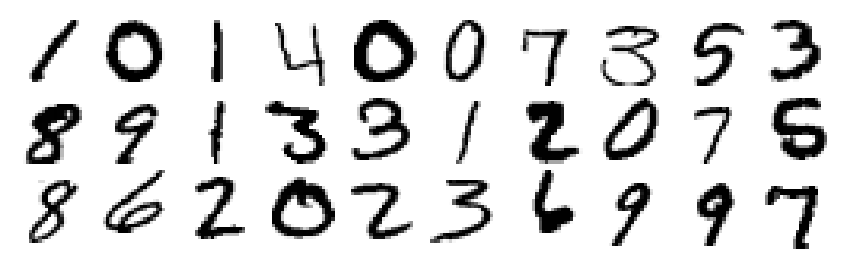

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [10]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images through any degree between 0 and 360
        zoom_range = 0.10,  
        width_shift_range=0.1, # a float number, that would indicate the percentage of width or height of the image to shift. 
        height_shift_range=0.1)

# datagen = ImageDataGenerator(
#         rotation_range=10,  
#         zoom_range = 0.10,  
#         width_shift_range=0.1, 
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=True,
#         brightness_range=[0.2,1.1],
#         )

In [11]:
X_train.shape # (42000, 28, 28, 1)
X_train[25,].shape # (28, 28, 1)
X_train[25,].reshape((1,28,28,1)).shape # (1, 28, 28, 1)


(1, 28, 28, 1)

### Each row of the total 42,000 rows represent a single image - now take a single one from them. lets say the image at row-index number 25

In [12]:
X_train[25,].shape

(28, 28, 1)

In [13]:
X_train[41999,].shape

(28, 28, 1)

### First see what this 25-row index image is

So below plot is before Augmentation

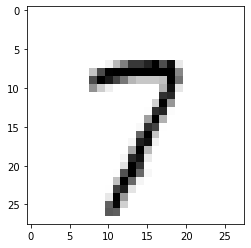

In [35]:
# plt.imshow(X_train[25,].reshape((28,28)),cmap=plt.cm.binary)
# plt.imshow(X_train[11,].reshape((28,28)),cmap=plt.cm.binary)
plt.imshow(X_train[18,].reshape((28,28)),cmap=plt.cm.binary)

## Plot a single Augmented Images by taking a single row of of data from the 42,000 number of samples

X_train[25,] => Will return all the columns but only row-index number 9

But to plot with the use of `datagen.flow` - I have to convert the above randomly selected row to a 4-D Tensor of shape `(1,28,28,1)`

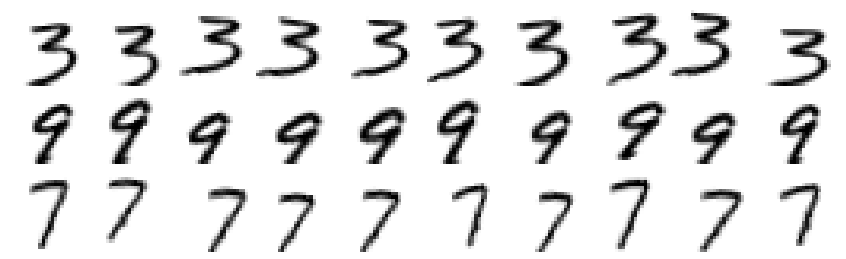

In [16]:
X_train_random = X_train[25,].reshape((1,28,28,1))
Y_train_random = Y_train[25,].reshape((1,10))

plt.figure(figsize=(15,4.5))

for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train_augmented, Y_train_augmented = datagen.flow(X_train_random,Y_train_random).next()
    plt.imshow(X_train_augmented[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    # Now for the second and third row take 2 different digit
    # 9 and 7 respectively
    # And because I am printing 9 columns for the same image, I have to 
    # advance the 'i' value by 10
    if i==9:
        X_train_random = X_train[11,].reshape((1,28,28,1))
    if i==19:
        X_train_random = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

---

### Build 15 Convolutional Neural Networks with bagging

### LeNet Architectural
![Imgur](https://imgur.com/by2Dc72.png)

In [24]:
def build_model(num_cnn):
    model = [0] *num_cnn
    for j in range(num_cnn):
        model[j] = Sequential()

        model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1))) # Two stacked 3x3 filters instead of single 5x5 filters. 
        model[j].add(BatchNormalization()) # Batch normalization is added
        model[j].add(Conv2D(32, kernel_size = 3, activation='relu')) # and ReLU activation replaces sigmoid.
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu')) # Stride 2 replaces pooling layers. These become learnable pooling layers.
        model[j].add(BatchNormalization())
        model[j].add(Dropout(0.4)) #  Dropout is added

        model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Dropout(0.4))

        model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Flatten())
        model[j].add(Dropout(0.4))
        model[j].add(Dense(10, activation='softmax'))

        model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model
    

In [25]:
num_cnn=10
model = build_model(num_cnn)

## Train 10 CNNs

In [22]:
def train(num_epochs):
    # Keep reducing the Learning Rate
    lr_scheduler = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    # Training starts
    history = [0] * num_cnn
    for cnn in range(num_cnn):
        X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
            X_train, Y_train, test_size=0.1
        )
        history[cnn] = model[cnn].fit(
            datagen.flow(X_train_split, Y_train_split, batch_size=64),
            epochs=num_epochs,
            steps_per_epoch=X_train_split.shape[0] // 64,
            validation_data=(X_val_split, Y_val_split),
            callbacks=[lr_scheduler],
            verbose=0,
        )
        print(
            "CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                cnn + 1,
                num_epochs,
                max(history[cnn].history["acc"]),
                max(history[cnn].history["val_acc"]),
            )
        )

In [ ]:
num_epochs = 45
train(num_epochs)

## Total image count

42,000 number of samples images * 90% Train Split Dataset * 45 epochs * 10 CNN => 17 Million

---

## [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/)


`tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)`

At the beginning of every epoch, this callback gets the updated learning rate value from schedule function provided at `__init__`, with the current epoch and current learning rate, and applies the updated learning rate on the optimizer.

Arguments

schedule: a function that takes an epoch index (integer, indexed from 0) and current learning rate (float) as inputs and returns a new learning rate as output (float).
verbose: int. 0: quiet, 1: update messages.


# Ensemble 10 CNN predictions and submit

In [ ]:
X_test.shape

(28000, 28, 28, 1)

In [ ]:
final_ensemble_prediction = np.zeros( (X_test.shape[0],10) ) 

final_ensemble_prediction.shape

(28000, 10)

# Final ensemble

In [ ]:
for j in range(num_cnn):
    final_ensemble_prediction = final_ensemble_prediction + model[j].predict(X_test)

    final_ensemble_prediction = np.argmax(final_ensemble_prediction,axis = 1)

    final_ensemble_prediction = pd.Series(final_ensemble_prediction,name="Label")

    submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),final_ensemble_prediction],axis = 1)

    submission.to_csv("MNIST_ensemble_cnn.csv",index=False)